## Change point detection of COVID-19 cases using Bayesian modelling
Using a Bayesian model for estimating the date that the distribution of new COVID-19 cases in a particular country changes

### References
* [Wikipedia: Timeline of the COVID-19 pandemic in the United Kingdom](https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_the_United_Kingdom)
* [Wikipedia: COVID-19 pandemic in the United Kingdom](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_Kingdom)


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.1, color_codes=True)
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100  # fig size

In [2]:
data = pd.read_csv("./data/covid_19_clean_20200519.csv")
data.Date = pd.to_datetime(data.Date)

# use only canada for now
cad = data.loc[data["Country/Region"] == "Canada", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
cad.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
cad = cad.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
cad.date = pd.to_datetime(cad.date)
cad = cad.sort_values(by = "date")
cad.tail()

,country,date,confirmed,deaths,recovered
114,Canada,2020-05-15,75959,5679,0
115,Canada,2020-05-16,77206,5800,0
116,Canada,2020-05-17,78332,5903,0
117,Canada,2020-05-18,79411,5960,0
118,Canada,2020-05-19,80493,6028,0


In [3]:
# countries with the most cases:
data.loc[data["Date"] == "2020-05-18", ["Country/Region", "Confirmed"]].sort_values(by = "Confirmed", 
                                                                                    ascending = False)[:7]

,Country/Region,Confirmed
31230,US,1508308
31192,Russia,290678
31033,Brazil,255368
31228,United Kingdom,246406
31206,Spain,231606
31142,Italy,225886
31121,France,177554


In [4]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country(country, end_date, state = False) : 
    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

    # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]

    # TODO check if the selected date range is intact

    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 
    
    # moving average for daily confirmed cases
    df["moving_avg"] = df.daily_confirmed.rolling(window=4).mean()

    return df

#
def plot_lines(df):

    country = df['country'].to_list()[0]

    fig, ax = plt.subplots(3,1, figsize=(12, 10), sharex=True)
    # accummulated cases
    sns.lineplot(x="date", 
                 y="confirmed", 
                 data= df,
                 ax = ax[0]
                ).set_title("Total Confirmed COVID-19 Cases in %s" % country)
    ax[0].set(ylabel='Daily Confirmed Cases', xlabel='')

    # daily confirmed cases, along with moving average
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 label = "Raw Data",
                 ax = ax[1])
    ax[1].set(ylabel='Daily Confirmed Cases', 
              xlabel='',
              title = "Daily New Confirmed COVID-19 Cases in %s" % country)

    # moving average of daily cases
    sns.lineplot(x = df.date, 
                 y = df.moving_avg, 
                 label = "Moving Average",
                 legend = "full",
                 ax = ax[2]).set_title("Daily New Confirmed COVID-19 Cases in %s" % country)

    # set x ticks
    dt_ticks = df['date'].to_list()[::14]
    dt_ticklabels = [i.strftime('%m/%d') for i in dt_ticks]
    for i in range(ax.shape[0]):
        ax[i].set_xticks(dt_ticks) # set sparse xticks
        ax[i].set_xticklabels(dt_ticklabels)

    ax[-1].set_xlabel("Date", labelpad=10)  # set xlabel
    # plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=30, horizontalalignment='right')  # rotate x ticks

    return fig, ax

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [5]:
df_uk = create_country("United Kingdom", end_date = "2020-05-18")  # UK
df_us = create_country("US", end_date = "2020-05-18")  # US

df_ca = create_country("Canada", end_date = "2020-04-30")  # Canada

df_it = create_country("Italy", end_date = "2020-05-18")  # Italy
df_es = create_country("Spain", end_date = "2020-05-18")  # Spain
df_de = create_country("Germany", end_date = "2020-05-18")  # Germany
df_cn = create_country("China", end_date = "2020-05-18")  # China

plot_lines(df_uk)
plot_lines(df_us)
plot_lines(df_ca)
plot_lines(df_cn)
pass

NameError: name 'df_cad' is not defined

In [6]:
# Check if the date range of the data is intact
date_rng = pd.date_range(start='20200122', end='20200518', freq='D', name='date')
print(date_rng[0], date_rng[-1], len(date_rng))

# UK 
print(df_uk.loc[0, 'date'], df_uk.loc[df_uk.index[-1], 'date'], df_uk['date'].shape[0])

2020-01-22 00:00:00 2020-05-18 00:00:00 118
2020-01-22 00:00:00 2020-05-18 00:00:00 118


In [7]:
# data filtering

# UK
uk_start = "2020-03-03" # 51 confirmed
df_uk = df_uk[df_uk.date >= uk_start].reset_index(drop = True)
df_uk["days_since_start"] = np.arange(df_uk.shape[0]) + 1

# US
us_start = "2020-02-26" # 57 confirmed cases
df_us = df_us[df_us.date >= us_start].reset_index(drop = True)
df_us["days_since_start"] = np.arange(df_us.shape[0]) + 1

# Canada
ca_start = "2020-02-27" # 13 confirmed cases
df_ca = df_ca[df_ca.date >= ca_start].reset_index(drop = True)
df_ca["days_since_start"] = np.arange(df_ca.shape[0]) + 1
print(df_ca.shape)

df_ca_tmp = df_ca[df_ca.date < '2020-03-28']
print(df_ca_tmp.shape)

# variable for data to easily swap it out:
country_ = "Canada (Before March 28th)"
reg_data = df_ca_tmp.copy()

(64, 8)
(30, 8)


In [8]:
# df_uk.head()
print(reg_data.shape)
reg_data.head()

(30, 8)


,country,date,confirmed,deaths,recovered,daily_confirmed,moving_avg,days_since_start
0,Canada,2020-02-27,13,0,0,2,1.00,1
1,Canada,2020-02-28,14,0,0,1,1.00,2
2,Canada,2020-02-29,20,0,0,6,2.25,3
3,Canada,2020-03-01,24,0,0,4,3.25,4
4,Canada,2020-03-02,27,0,0,3,3.50,5


### Proof of Concept (testing out piecewise regression to see if its reasonnable)

(19, 1)
Regression 1 weight:  0.18
Regression 1 bias:  0.23
Regression 2 weight:  0.23
Regression 2 bias:  0.04


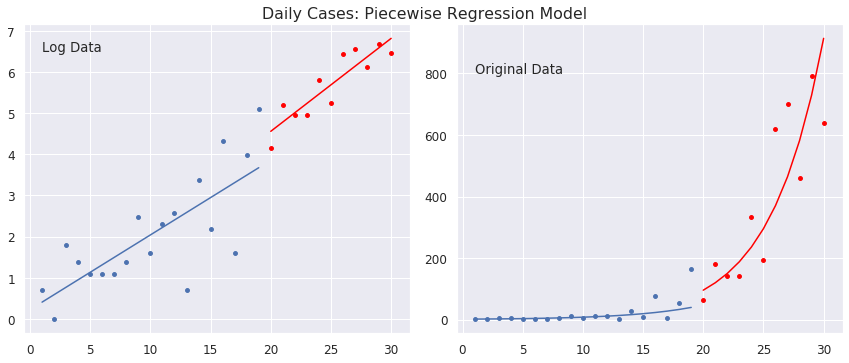

In [9]:
# just choose a random point to split on. difference here is that we have a closed form solution
_date = 20

# piece 1
df = reg_data[reg_data.days_since_start < _date]
x = np.array(df["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
print(x.shape)
y = np.log(np.array(df["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg = LinearRegression()
_ = reg.fit(x, y)
print("Regression 1 weight: ", round(reg.coef_[0][0], 2))
print("Regression 1 bias: ", round(reg.intercept_[0], 2))

# piece 2
df2 = reg_data[reg_data.days_since_start >= _date]
x2 = np.array(df2["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
y2 = np.log(np.array(df2["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg2 = LinearRegression()
_ = reg2.fit(x2, y2)
print("Regression 2 weight: ", round(reg2.coef_[0][0], 2))
print("Regression 2 bias: ", round(reg2.intercept_[0], 2))

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# log regression model
ax[0].scatter(x, y, s = 15)
ax[0].scatter(x2, y2, s = 15, color = "red")
ax[0].plot(x, x*reg.coef_[0][0] + reg.intercept_) 
ax[0].plot(x2, x2*reg2.coef_[0][0] + reg2.intercept_, color = "red") 
# ax[0].set(title = "Daily Cases: Piecewise Regression Model - Log Data")
ax[0].text(1, 6.5, 'Log Data')

ax[1].scatter(x, np.exp(y), s = 15)
ax[1].scatter(x2, np.exp(y2), s = 15, color = "red")
ax[1].plot(x, np.exp(x*reg.coef_[0][0] + reg.intercept_))
ax[1].plot(x2, np.exp(x2*reg2.coef_[0][0] + reg2.intercept_), color = "red")
# ax[1].set(title = "Daily Cases: Piecewise Regression Model - Original Data")
ax[1].text(1, 800, 'Original Data')

fig.suptitle("Daily Cases: Piecewise Regression Model", y=1.01)

plt.tight_layout()
plt.show()

## Change point estimation using Pyro

In [10]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive